In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# changing directory to the file location in drive
%cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
import pandas as pd
import datetime
import calendar
import os
import glob

In [ ]:
path = "/content/drive/MyDrive/Naija Apps & Review/data/new csvs"

# read files from folder
data_files = [file for file in os.listdir(path) if '.csv' in file]  # ignore hidden files
all_data = pd.DataFrame()
for file in data_files:
  current_data = pd.read_csv(path+"/"+file)
  all_data = pd.concat([all_data, current_data], axis = 0)



 # the csv data here should be saved after data preparation and preprocessing
all_data.to_csv("ModifiedNaijaApps.csv", index=False) # save data to csv


In [ ]:
all_data.head(2)

,title,summary,free,genre,installs,ratings,price,size,contentRating,reviews,released,adSupported,sale,score,similarApps,version
0,EMDEX,Nigeria’s mobile drug reference & therapeutic ...,True,Medical,"50,000+",719.0,0.0,12M,Rated for 3+,465.0,"Jul 5, 2018",True,False,4.600000,['com.mobisystems.msdict.embedded.wireless.els...,2.5.1
1,SUNU Health,Experience the SUNU Health Mobile to access wo...,True,Medical,"5,000+",34.0,0.0,3.6M,Rated for 3+,14.0,"Jul 9, 2018",NaN,False,4.558824,"['com.senenews', 'com.nextwebart.senego']",1.1.8


In [ ]:
# We try to rename certain columns for easy identification
all_data.rename(columns={'title': 'appName', 'genre': 'category'}, inplace=True)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1938 entries, 0 to 357
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   appName        1938 non-null   object 
 1   summary        1938 non-null   object 
 2   free           1938 non-null   bool   
 3   category       1938 non-null   object 
 4   installs       1938 non-null   object 
 5   ratings        1391 non-null   float64
 6   price          1938 non-null   float64
 7   size           1938 non-null   object 
 8   contentRating  1938 non-null   object 
 9   reviews        1928 non-null   float64
 10  released       1928 non-null   object 
 11  adSupported    1022 non-null   object 
 12  sale           1938 non-null   bool   
 13  score          1928 non-null   float64
 14  similarApps    1684 non-null   object 
 15  version        1935 non-null   object 
dtypes: bool(2), float64(4), object(10)
memory usage: 230.9+ KB


In [ ]:
all_data["contentRating"].value_counts()

Rated for 3+     1717
Rated for 12+     172
Rated for 18+      28
Rated for 16+      21
Name: contentRating, dtype: int64

In [ ]:
all_data["size"].value_counts()

11M                   55
16M                   53
12M                   46
Varies with device    46
13M                   44
                      ..
82M                    1
1,015k                 1
94M                    1
186M                   1
999k                   1
Name: size, Length: 192, dtype: int64

> Change the data type of the following columns to integers:
- Installs
- Size
- Ratings

> Change the Released date to datetime and extract the Month and Year.

> In size, convert kB to MB, then change the data to integer.
> We'll use the size to compare to the number of installs

> Fill the null values for adSupported with "Unknown"

> Null values for "Ratings" yet to be decided*


> Null values for reviews and released.
- Drop the rows without a relased date
- Drop the row that has the highest ratings, to remove the outlier and have a more balanced data. We can then use the mean to fill the null values.


In [ ]:
all_data.describe()

,ratings,price,reviews
count,1486.000000,2126.000000,2116.000000
mean,2832.127860,23.966308,1066.890832
std,28254.714163,829.221134,11528.671356
min,5.000000,0.000000,0.000000
25%,14.000000,0.000000,0.000000
50%,39.500000,0.000000,9.000000
75%,162.500000,0.000000,42.250000
max,849269.000000,38000.000000,362096.000000


In [ ]:
## fetching the row number review outlier for dropping
all_data['reviews'].max()

377599.0

## Data Cleaning

Suggested data types for some of the columns:

1. Installs should be numerical. We can strip off "+"
2. Released should be datetime since it's a date
3. contentRating should be object/str. 

### Converting all categorical features to numeric


In [ ]:
all_data['Day_of_the_week'].value_counts()

0.0    305
4.0    291
2.0    290
1.0    290
3.0    278
5.0    244
6.0    230
Name: Day_of_the_week, dtype: int64

In [ ]:
# Extract month and year
all_data[['month', 'year']] = all_data['released'].str.split(',', expand=True)

all_data['released'] = pd.to_datetime(all_data['released']) 

# extract weeekday
mapper = {
    0.0: 'Monday', 1.0: 'Tuesday', 2.0: 'Wednesday', 3.0: 'Thursday',
    4.0: 'Friday', 5.0: 'Saturday', 6.0: 'Sunday',
}
all_data['day_of_week'] = all_data['released'].apply(lambda time: time.dayofweek)
# mapp all integer variables
all_data['day_of_week'] = all_data['day_of_week'].replace(mapper)

# remove special character from installs and convert to integer
all_data['installs'] = all_data['installs'].str.replace('+', '')
all_data['installs'] = all_data['installs'].str.replace(',', '').astype('int')
# # Convert the content rating
# all_data['contentRating'] = all_data['contentRating'].map(lambda x: x.lstrip('Rated for').rstrip('+'))
# all_data['contentRating'] = all_data['contentRating'].astype("int")
all_data.head()

,appName,summary,free,category,installs,ratings,price,size,contentRating,reviews,released,adSupported,sale,score,similarApps,version,month,year,day_of_week
0,EMDEX,Nigeria’s mobile drug reference & therapeutic ...,True,Medical,50000,719.0,0.0,12M,Rated for 3+,465.0,2018-07-05,True,False,4.600000,['com.mobisystems.msdict.embedded.wireless.els...,2.5.1,Jul 5,2018,Thursday
1,SUNU Health,Experience the SUNU Health Mobile to access wo...,True,Medical,5000,34.0,0.0,3.6M,Rated for 3+,14.0,2018-07-09,NaN,False,4.558824,"['com.senenews', 'com.nextwebart.senego']",1.1.8,Jul 9,2018,Monday
2,PriveDoc,Connecting all of Nigeria with high quality ef...,True,Medical,1000,669.0,0.0,159M,Rated for 3+,600.0,2018-10-23,NaN,False,4.960396,"['com.dayuse_hotels.dayuseus', 'com.spektra.in...",2.2.1,Oct 23,2018,Tuesday
3,TB STARR,"TB STARR helps manage screening, referral, & r...",True,Medical,1000,31.0,0.0,12M,Rated for 3+,11.0,2019-07-01,NaN,False,4.419355,['com.shelfwatch'],1.8.2,Jul 1,2019,Monday
4,myDokita,myDokita is telemedicine app that lets you con...,True,Medical,1000,12.0,0.0,32M,Rated for 3+,7.0,2020-06-09,NaN,False,3.166667,"['us.drpad.drpadapp', 'com.lafiya.telehealth',...",1.0.1,Jun 9,2020,Tuesday


In [ ]:
'''The cell below is me trying to explore the price feature and to figure what we can make out of it, so this is what i discovered
0.0 = apps that are free
non zeros = apps that are paid with their respective price tag
 '''
all_data['price'].value_counts()  # what currencies are these prices in? Naira?

0.00        1926
1990.00        3
200.00         2
1500.00        1
38000.00       1
197.37         1
1200.00        1
500.00         1
385.00         1
100.00         1
Name: price, dtype: int64

# Analysis on categorical level

In [ ]:
# We will be working on the preprocessing all our data here for a better analysis
# import libraries
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import altair as alt
import plotly
import plotly.express as px
from IPython.display import display, HTML
%matplotlib inline

### Most popular category for Naija apps


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



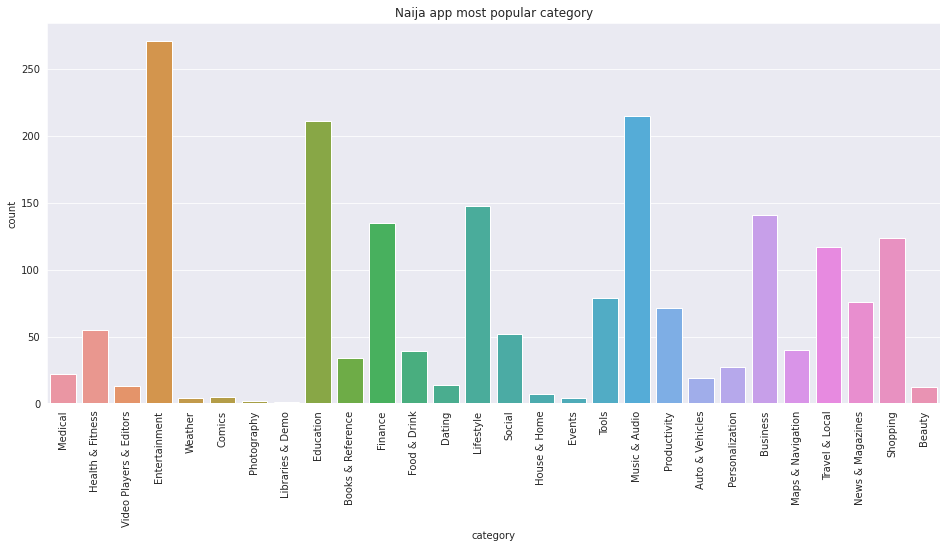

,category,Count
7,Entertainment,271
17,Music & Audio,215
6,Education,211
14,Lifestyle,148
3,Business,141


In [ ]:
plt.figure(figsize=(16, 7))
#fig, ax = plt.subplots()
sns.countplot(all_data.category)
plt.xticks(rotation=90)
plt.title('Naija app most popular category')
plt.show()

# Tabluar visualization for the top 5 most popular app
Top_5 = all_data.groupby('category').size().reset_index(name='Count').nlargest(5, 'Count')
display(Top_5)

##### With the top five most popular category, we can see which of these catgeory was installed the most.

In [ ]:
top_5 = Top_5['category'].tolist()
top_pop = all_data.groupby('category')['installs'].agg(sum).loc[top_5].reset_index(name='Total Installs')
# compairing installation across all category
data = all_data.groupby('category')['installs'].agg('sum').reset_index(name='Total Installs')

In [ ]:
# altair plot
fig = alt.Chart(top_pop).mark_bar().properties(width=500).encode(
    x = 'category',
    y = 'Total Installs'
)
fig

alt.Chart(...)

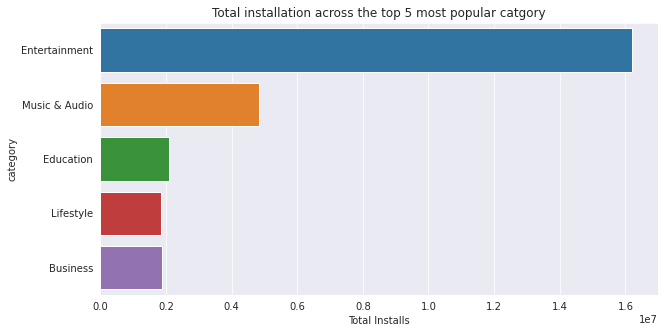

In [ ]:
fig = plt.figure(figsize=(10, 5))
title = plt.title('Total installation across the top 5 most popular catgory')
viz = sns.barplot(y=top_pop['category'], x=top_pop['Total Installs'])
plt.show(viz)

#### We also visualize total installation across all category

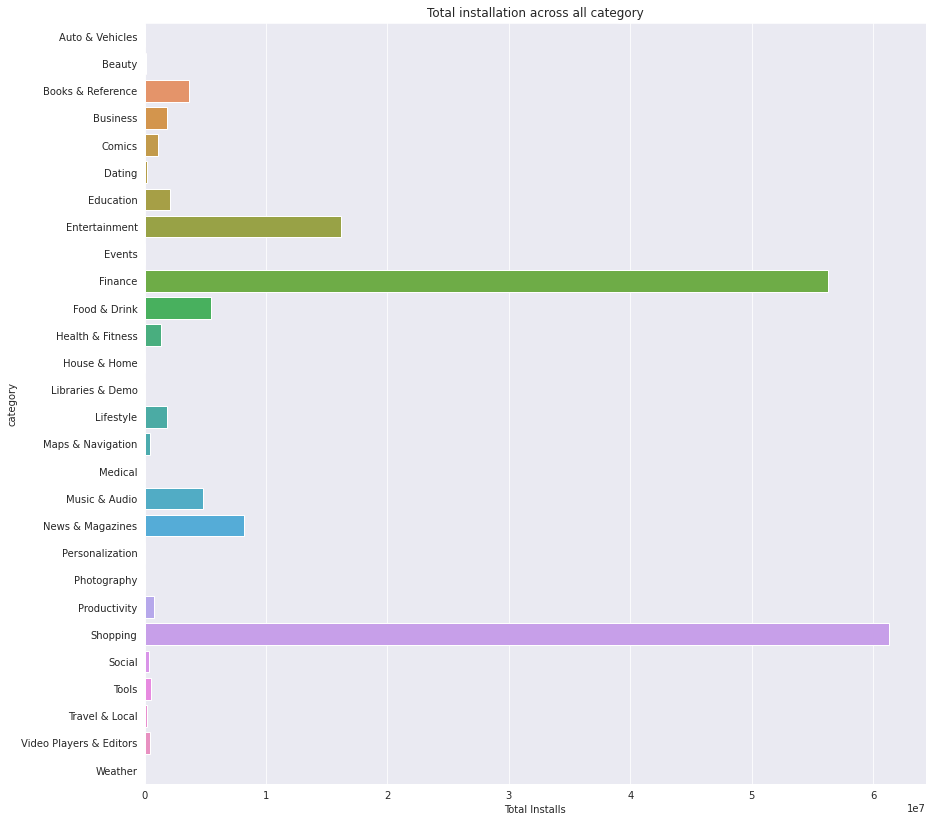

In [ ]:
# we can see the entertainment category was the most popular and yet wasn't among the most installed apps
# this thereby shows nigerians develop more of entertainment apps whereas people look out for apps that create values as we have below
# shopping and financial apps having the highest installaion
plt.figure(figsize=(14, 14))
plt.title('Total installation across all category')
bar = sns.barplot(y=data['category'], x= data['Total Installs'])
plt.show(bar)

### We also look at the top most rated category

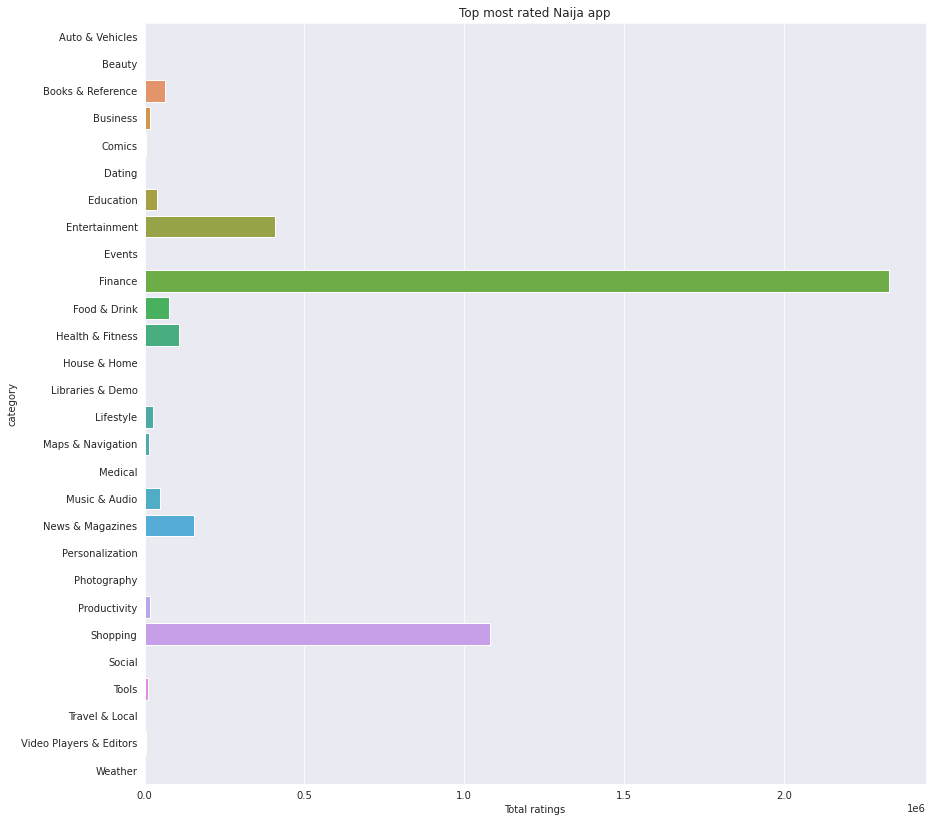

In [ ]:
# obviously we can see a positive correlation betweeen the installation and ratings. More rated apps attract more downloads
cat_rate = all_data.groupby('category')['ratings'].agg('sum').reset_index(name='Total ratings')
plt.figure(figsize=(14, 14))
plt.title('Top most rated Naija app')
bar = sns.barplot(y=cat_rate['category'], x= cat_rate['Total ratings'])
plt.show(bar)

#### We also look at the category with the most review


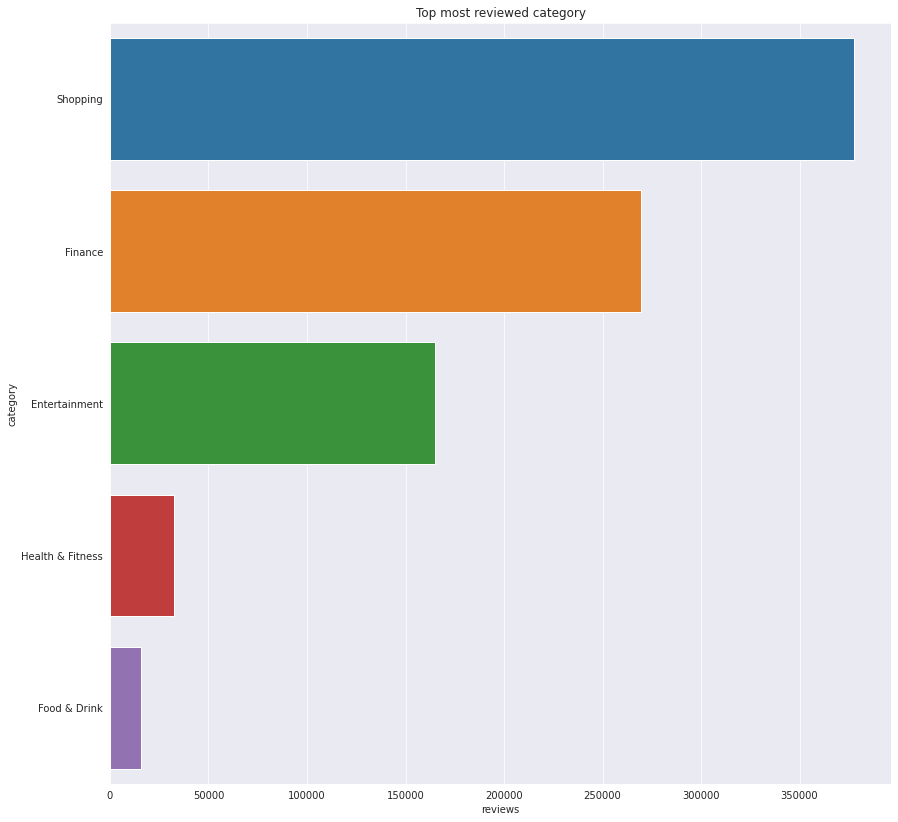

In [ ]:
cat_review = all_data.groupby('category', as_index=False)['reviews'].max().sort_values('reviews', ascending=False).head()
plt.figure(figsize=(14, 14))
plt.title('Top most reviewed category')
viz = sns.barplot(data=cat_review, x='reviews', y='category')
plt.show(viz)


#### Here we also look at the catgory we the most ratings

Text(0.5, 1.0, 'Most Rated Category')

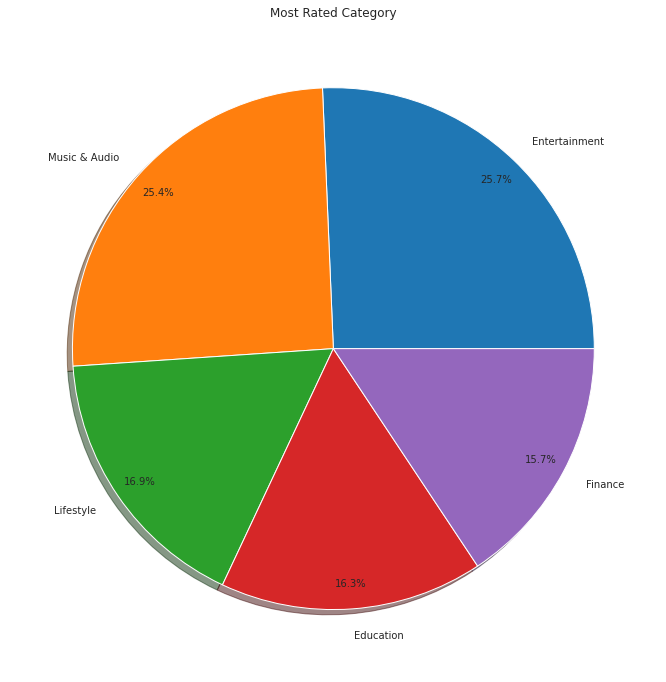

In [ ]:
cat_rating = all_data.groupby('category')['ratings'].count()
cat_rating = cat_rating.sort_values(ascending=False).head(5)
pie, ax = plt.subplots(figsize=[15, 12])
plt.xticks(rotation='horizontal')
labels = cat_rating.keys()
plt.pie(x=cat_rating, autopct="%.1f%%", shadow=True, labels=labels, pctdistance=0.9)
plt.title('Most Rated Category')

#### We also look at between free apps and paid apps which category is downloaded the most

Text(0.5, 1.0, 'Paid apps vs free apps with respect to installation')

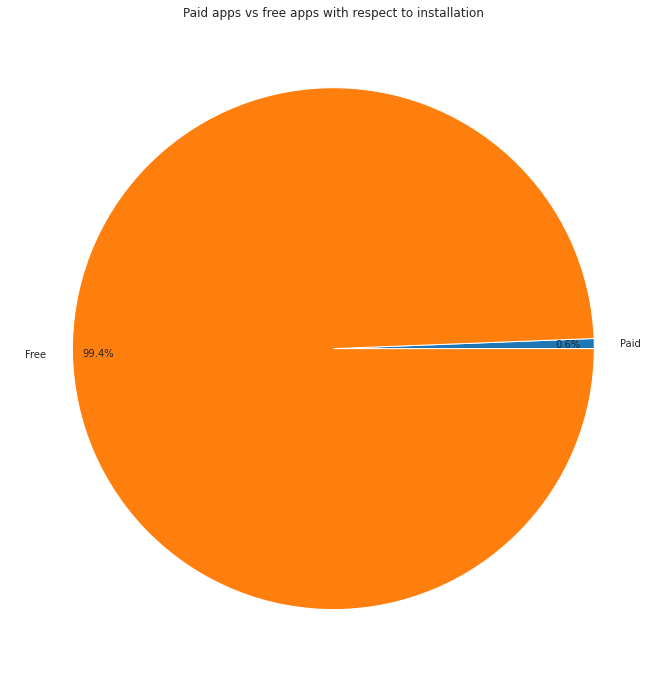

In [ ]:
app_type = all_data.groupby('free')['installs'].count()
pie, ax = plt.subplots(figsize=[15, 12])
plt.xticks(rotation='horizontal')
labels = ['Paid', 'Free']
plt.pie(x=app_type, autopct="%.1f%%", labels=labels, pctdistance=0.9)
plt.title('Paid apps vs free apps with respect to installation')


## Download trend by week day


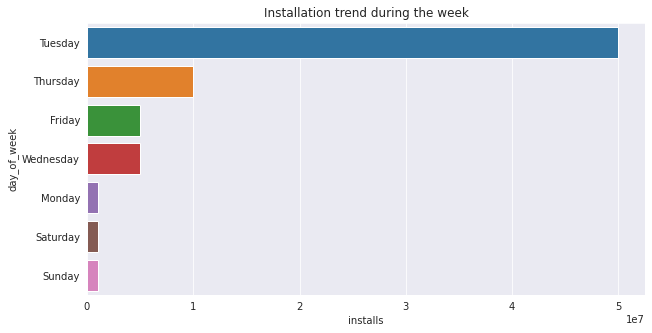

In [ ]:
# day of the week vs download
day = all_data.groupby('day_of_week', as_index=False)['installs'].max().sort_values('installs', ascending=False)
plt.figure(figsize=(10, 5))
plt.title('Installation trend during the week')
viz = sns.barplot(data=day, x='installs', y='day_of_week')
plt.show(viz)


Text(0.5, 1.0, 'Day of the Week with most review')

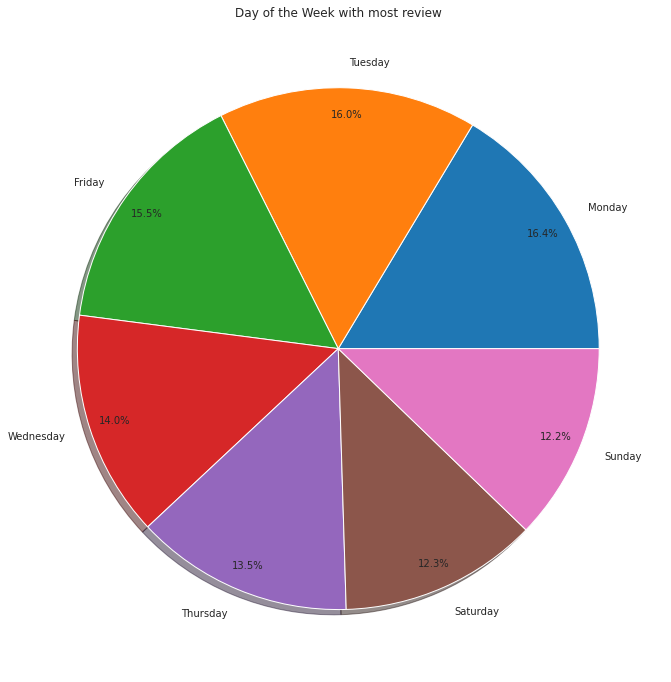

In [ ]:
# what day of the week had the most review
dayr = all_data.groupby('day_of_week')['ratings'].count()
dayr = dayr.sort_values(ascending=False)
pie, ax = plt.subplots(figsize=[15, 12])
plt.xticks(rotation='horizontal')
labels = dayr.keys()
plt.pie(x=dayr, autopct="%.1f%%", shadow=True, labels=labels, pctdistance=0.9)
plt.title('Day of the Week that got the most reviews')

In [ ]:
# this is plot is not valid yet will work on it
day = all_data.groupby('day_of_week', as_index=False)['installs'].max().sort_values('installs', ascending=False)
fig = px.line_polar(day, theta='day_of_week', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
        )),
        showlegend=True
    )
fig

# Analysis on App level and its features

In [ ]:
labels = 

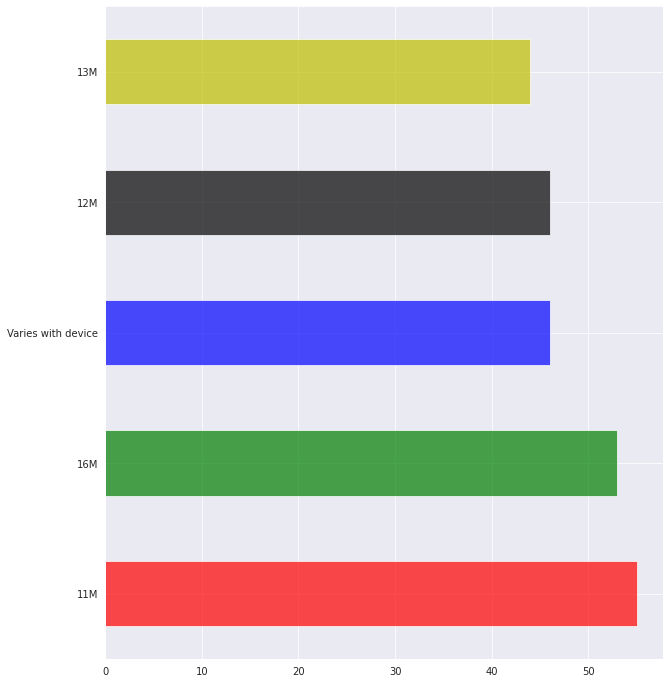

In [ ]:
# There is a slight correlation between the number of downloads and the size of an app which implies the smaller the app in size,
# the more number of installs it will attract
all_data['size'].value_counts().sort_values(ascending=False).head(5).plot(kind='barh', color=list('rgbkymc'),
                                              alpha=0.7, figsize=(10, 12))
plt.show()

Looking at what year that attracted the most number of downloaded apps and why?

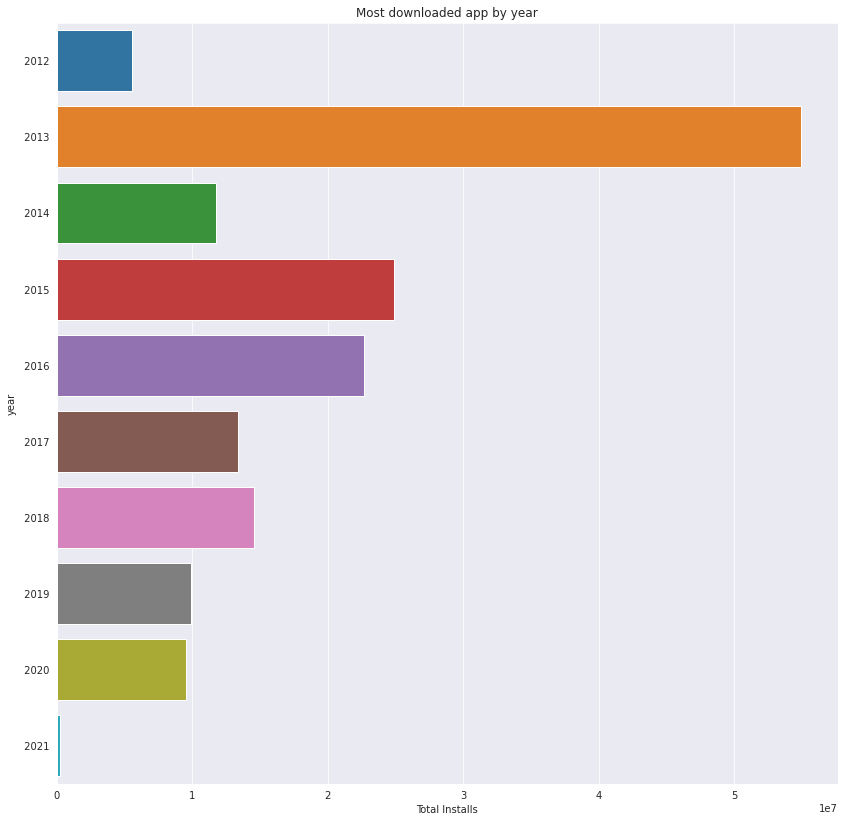

In [ ]:
yearly_data = all_data.groupby('year')['installs'].agg('sum').reset_index(name='Total Installs')
plt.figure(figsize=(14, 14))
plt.title('Most downloaded app by year')
bar = sns.barplot(y=yearly_data['year'], x= yearly_data['Total Installs'])
plt.show(bar)

##### Lets compare the statistics between price of free apps and paid apps with respect to total rating

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



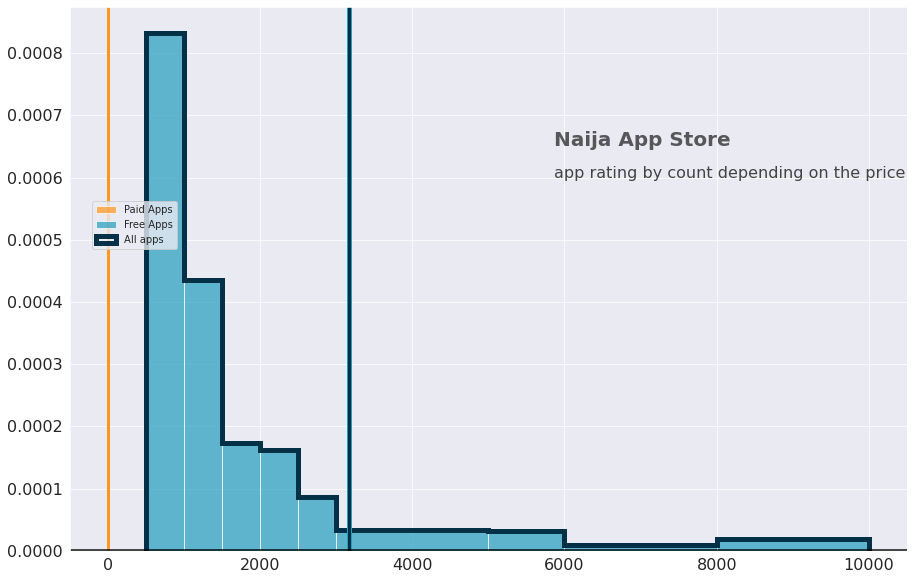

In [ ]:
free_apps = all_data[all_data['price']==0]
paid_apps =  all_data[all_data['price'] != 0]

plt.figure(figsize=(15, 10))
bins = [500, 1000, 1500, 2000, 2500, 3000, 5000, 6000, 8000, 10000]
graph = sns.distplot(paid_apps['ratings'], norm_hist=True, color='#FF961F', label='Paid Apps',
                      bins=bins, kde=False, hist_kws={"histtype": "bar", "alpha": .7})
graph = sns.distplot(free_apps['ratings'], norm_hist= True, color= '#219ebc', label='Free Apps', bins=bins, kde=False,
                     hist_kws={'histtype':'bar', 'alpha': .7})
graph = sns.distplot(all_data['ratings'], norm_hist=True, color = '#023047', label= 'All apps', bins=bins, kde=False,
                    hist_kws = {'histtype': 'step', 'alpha': 1, 'linewidth': 5})

# Display their mean
graph.axvline(x=paid_apps['ratings'].mean(), color='#FF961F', linewidth=3, alpha=1)
graph.axvline(x=free_apps['ratings'].mean(), color='#219ebc', linewidth=5, alpha=1)
graph.axvline(x=all_data['ratings'].mean(), color='#023047', linewidth=3, alpha=1)

# display graphics details
graph.text(x=0.5, y=0.5, s='Naija App Store', fontsize=20, weight='bold', alpha=.75, transform=ax.transAxes)
graph.text(x=0.5, y=0.45, s = 'app rating by count depending on the price', fontsize=16, alpha=.85, transform=ax.transAxes)
graph.tick_params(axis='both', which ='major', labelsize=16)
graph.axhline(y=0, color='black', linewidth=4, alpha=.7)
#graph.set_xlim(left=1.9, right=5)
graph.xaxis.label.set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(0.02, 0.60))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



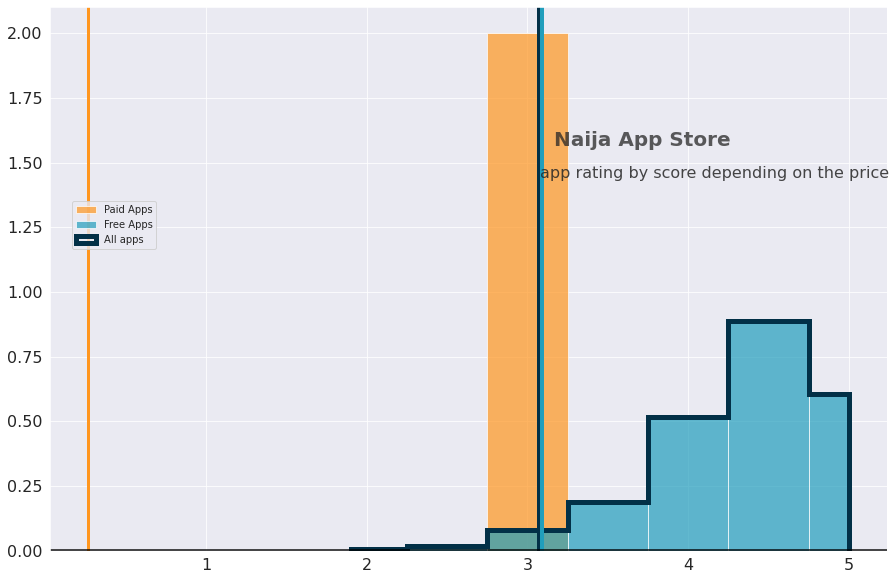

In [ ]:
free_apps = all_data[all_data['price']==0]
paid_apps =  all_data[all_data['price'] != 0]

plt.figure(figsize=(15, 10))
bins = [1.9, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5]
graph = sns.distplot(paid_apps['score'], norm_hist=True, color='#FF961F', label='Paid Apps',
                      bins=bins, kde=False, hist_kws={"histtype": "bar", "alpha": .7})
graph = sns.distplot(free_apps['score'], norm_hist= True, color= '#219ebc', label='Free Apps', bins=bins, kde=False,
                     hist_kws={'histtype':'bar', 'alpha': .7})
graph = sns.distplot(all_data['score'], norm_hist=True, color = '#023047', label= 'All apps', bins=bins, kde=False,
                    hist_kws = {'histtype': 'step', 'alpha': 1, 'linewidth': 5})

# Display their mean
graph.axvline(x=paid_apps['score'].mean(), color='#FF961F', linewidth=3, alpha=1)
graph.axvline(x=free_apps['score'].mean(), color='#219ebc', linewidth=5, alpha=1)
graph.axvline(x=all_data['score'].mean(), color='#023047', linewidth=3, alpha=1)

# display graphics details
graph.text(x=0.5, y=0.5, s='Naija App Store', fontsize=20, weight='bold', alpha=.75, transform=ax.transAxes)
graph.text(x=0.48, y=0.45, s = 'app rating by score depending on the price', fontsize=16, alpha=.85, transform=ax.transAxes)
graph.tick_params(axis='both', which ='major', labelsize=16)
graph.axhline(y=0, color='black', linewidth=4, alpha=.7)
#graph.set_xlim(left=1.9, right=5)
graph.xaxis.label.set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(0.02, 0.60))
plt.show()

### We also look at how Monthly days affect total number of downloads

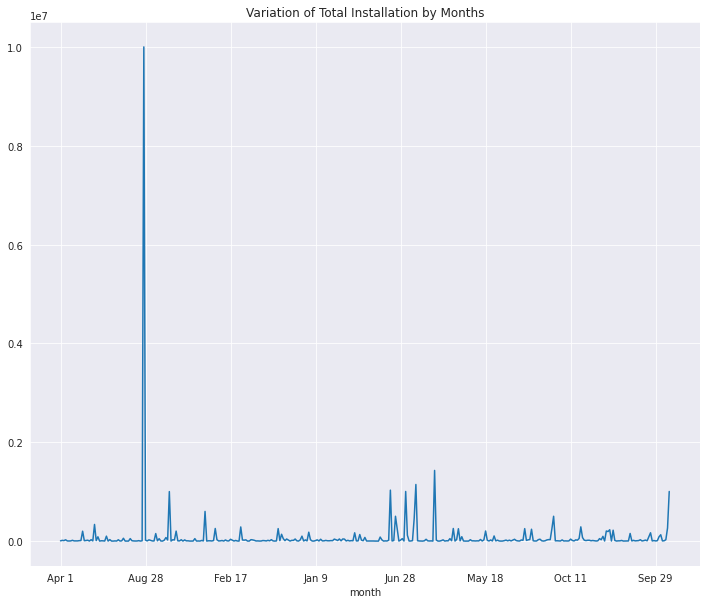

In [ ]:
monthly_data = all_data.groupby('month').mean()
fig, ax = plt.subplots(figsize=(12, 10))
#ax.xaxis.set(ticks=range(0, 31))
plt.xticks(rotation=90)
monthly_data['installs'].plot(x=all_data.month)
plt.title('Variation of Total Installation by Months')
plt.show()


### We also look at app size that was rated more

In [ ]:
# we select the top 5 app sizes for clear comparison
df_11mb = all_data[all_data['size']=='11M']
df_12mb = all_data[all_data['size']=='12M']
df_13mb = all_data[all_data['size']=='13M']
df_16mb = all_data[all_data['size']=='16M']
device_df = all_data[all_data['size']=='Varies with device']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



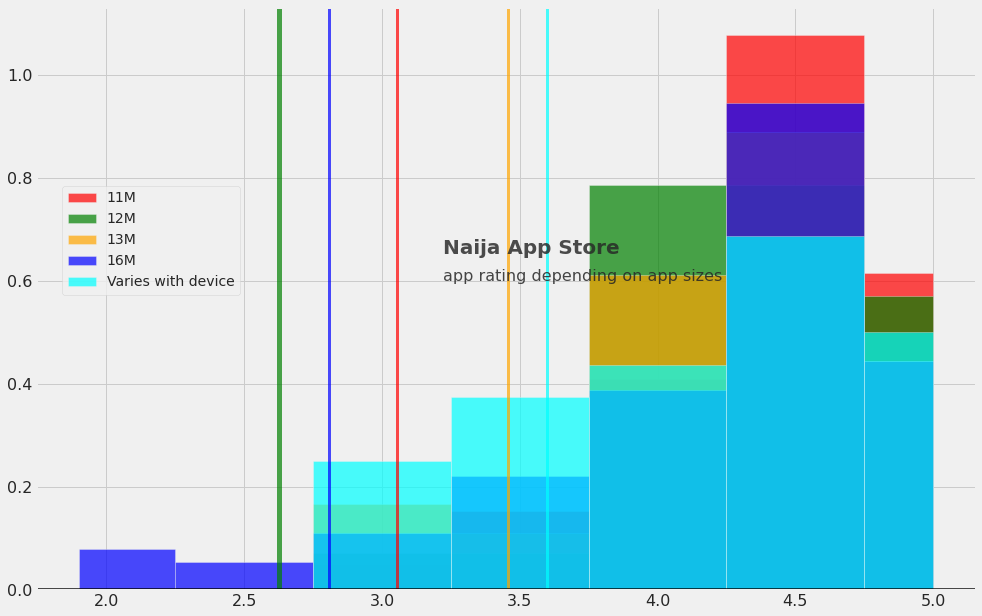

In [ ]:
plt.style.use('fivethirtyeight')
figure = plt.figure(figsize=(15, 10))
bins = [1.9, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5]
graph = sns.distplot(df_11mb['score'], norm_hist=True, color='red', label='11M',
                      bins=bins, kde=False, hist_kws={"histtype": "bar", "alpha": .7})
graph = sns.distplot(df_12mb['score'], norm_hist= True, color= 'green', label='12M', bins=bins, kde=False,
                     hist_kws={"histtype": "bar", "alpha" : .7})
graph = sns.distplot(df_13mb['score'], norm_hist= True, color= 'orange', label='13M', bins=bins, kde=False,
                     hist_kws={'histtype':'bar', 'alpha': .7})
graph = sns.distplot(df_16mb['score'], norm_hist= True, color= 'blue', label='16M', bins=bins, kde=False,
                     hist_kws={'histtype':'bar', 'alpha': .7})
graph = sns.distplot(device_df['score'], norm_hist= True, color= 'cyan', label='Varies with device', bins=bins, kde=False,
                     hist_kws={'histtype':'bar', 'alpha': .7})
# graph = sns.distplot(all_data['score'], norm_hist=True, color = '#023047', label= 'All apps', bins=bins, kde=False,
#                     hist_kws = {'histtype': 'step', 'alpha': 1, 'linewidth': 5})

# Display their mean
graph.axvline(x=df_11mb['score'].mean(), color='red', linewidth=3, alpha=.7)
graph.axvline(x=df_12mb['score'].mean(), color='green', linewidth=5, alpha=.7)
graph.axvline(x=df_13mb['score'].mean(), color='orange', linewidth=3, alpha=.7)
graph.axvline(x=df_16mb['score'].mean(), color='blue', linewidth=3, alpha=.7)
graph.axvline(x=device_df['score'].mean(), color='cyan', linewidth=3, alpha=.7)
#graph.axvline(x=all_data['score'].mean(), color='#023047', linewidth=3, alpha=1)

# display graphics details
graph.text(x=0.5, y=0.5, s='Naija App Store', fontsize=20, weight='bold', alpha=.82, transform=ax.transAxes)
graph.text(x=0.5, y=0.45, s = 'app rating depending on app sizes', fontsize=16, alpha=.85, transform=ax.transAxes)
graph.tick_params(axis='both', which ='major', labelsize=16)
graph.axhline(y=0, color='black', linewidth=4, alpha=.7)
#graph.set_xlim(left=1.9, right=5)
graph.xaxis.label.set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(0.02, 0.60))
plt.show(figure)

## We look at the content rating if it has an effect on installation. Content rating is simply apps that target the right audience and how its rated in that audience category

In [ ]:
# number of installations per content rating
content_instal = all_data.groupby('contentRating')['installs'].agg('sum').reset_index(name='Number_Installations')
# number of installation per app per content rating
app_no = all_data.groupby('contentRating')['installs'].size().reset_index(name='Number of Apps')

In [ ]:
content_instal

,contentRating,Number_Installations
0,Rated for 12+,63822120
1,Rated for 16+,424750
2,Rated for 18+,458900
3,Rated for 3+,102755858


In [ ]:
app_no

,contentRating,Number of Apps
0,Rated for 12+,172
1,Rated for 16+,21
2,Rated for 18+,28
3,Rated for 3+,1717


### According to google play store 

- 12+ describes apps that may contain undesirable or infrequent mild languages, or gambling that may not be suitable for the kids under the age of 12

- 16+ describes depiction of violence or anything related to sexual activities
- 18+ describes apps that are strictly intended for those ranging from 18yrs and above
- 3+ describes apps that the app is appropriate for people aged more than 3,this app however can be seen as normal

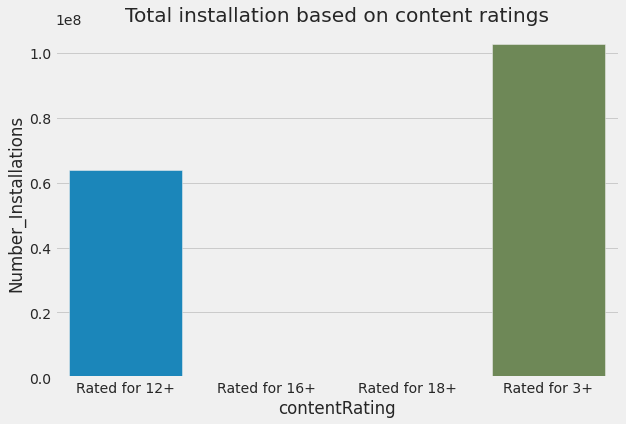

In [ ]:
# let visualize content rating in a chart
# And as we can see we have more naija apps rated for 3+ which explains why we have a huge number of download
# in that category. Therefore we can conclude that cotent rating has a huge impact on number installs

fig = plt.figure(figsize=(9, 6))
plt.title('Total installation based on content ratings')
bar = sns.barplot(x=content_instal.contentRating, y=content_instal.Number_Installations)
plt.show(bar)

In [ ]:

#fig = plt.figure(figsize=(9, 6))
#plt.title('Total installation based on content ratings')
# Using plotly
fig = px.bar(x=content_instal.contentRating, y=content_instal.Number_Installations, height=500)
fig.show()

In [ ]:
# ratings of apps
base = alt.Chart(all_data,
                 title = 'Content Rating Dependencies'
                 ).properties(width=500)

plot1 = base.mark_line(point=True).encode(
    alt.X('reviews', title = 'Number of rating of apps (reviews)'),
    alt.Y('installs', title = 'Total installation (installs)'),
    #alt.Size('score', title = 'star rating of apps (score)'),
    alt.Color('contentRating', title = 'Target audience (contentRating)'),
    
    tooltip = [alt.Tooltip('reviews'),
              alt.Tooltip('installs'),
             # alt.Tooltip('score')
              ]
)

(plot1).interactive()

alt.Chart(...)

We also look at content rating based on their score(star) given on google play store

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



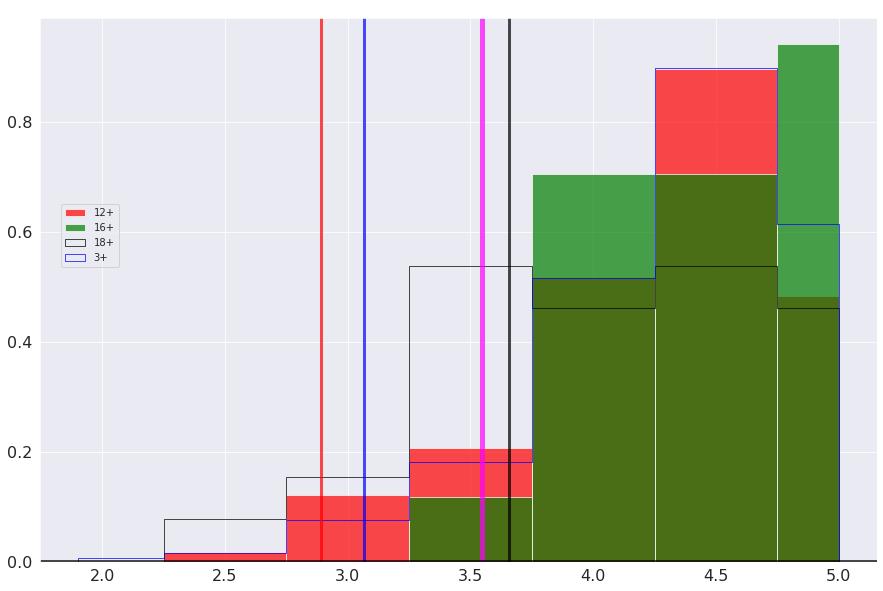

In [ ]:
cat_12 = all_data[all_data['contentRating']=='Rated for 12+']
cat_16 = all_data[all_data['contentRating']=='Rated for 16+']
cat_18 = all_data[all_data['contentRating']=='Rated for 18+']
cat_3 = all_data[all_data['contentRating']=='Rated for 3+']


plt.figure(figsize=(10, 8))
bins = [1.9, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5]
graph = sns.distplot(cat_12['score'], norm_hist=True, color='red', label='12+',
                      bins=bins, kde=False, hist_kws={"histtype": "bar", "alpha": .7})
graph = sns.distplot(cat_16['score'], norm_hist= True, color='green', label='16+', bins=bins, kde=False,
                     hist_kws={'histtype':'bar', 'alpha': .7})
graph = sns.distplot(cat_18['score'], norm_hist=True, color = 'black', label= '18+', bins=bins, kde=False,
                    hist_kws = {'histtype': 'step', 'alpha': 1, 'linewidth': .7})

graph = sns.distplot(cat_3['score'], norm_hist=True, color='blue', label= '3+', bins=bins, kde=False,
                    hist_kws = {'histtype': 'step', 'alpha': 1, 'linewidth': .7})
#graph = sns.distplot(all_data['score'], norm_hist=True, label= 'All apps', bins=bins, kde=False,
 #                   hist_kws = {'histtype': 'step', 'alpha': 1, 'linewidth': 5})

# Display their mean
graph.axvline(x=cat_12['score'].mean(), color = 'red', linewidth=3, alpha=.7)
graph.axvline(x=cat_16['score'].mean(),color = 'magenta',linewidth=5, alpha=.7)
graph.axvline(x=cat_18['score'].mean(), color='black', linewidth=3, alpha=.7)
graph.axvline(x=cat_3['score'].mean(), color='blue', linewidth=3, alpha=.7)
#graph.axvline(x=all_data['score'].mean(), linewidth=3, alpha=.7)

# display graphics details
graph.text(x=0.1, y=0.8, s='Naija App Store', fontsize=20, weight='bold', alpha=.85, transform=ax.transAxes)
graph.text(x=0.1, y=0.75, s = 'app rating based on content rating', fontsize=16, alpha=.85, transform=ax.transAxes)
graph.tick_params(axis='both', which ='major', labelsize=16)
graph.axhline(y=0, color='black', linewidth=4, alpha=.7)
#graph.set_xlim(left=1.9, right=5)
graph.xaxis.label.set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(0.02, 0.60))
plt.show()

Another interesting we can take a look at is app name how it influences download. On personal note apps with really looong name are paid less attention when it comes to installation than the ones with well simplified names. This is only but a proposition our data should be able to tells if this claim is true or not

- Now we will compare the length of app names to installation


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


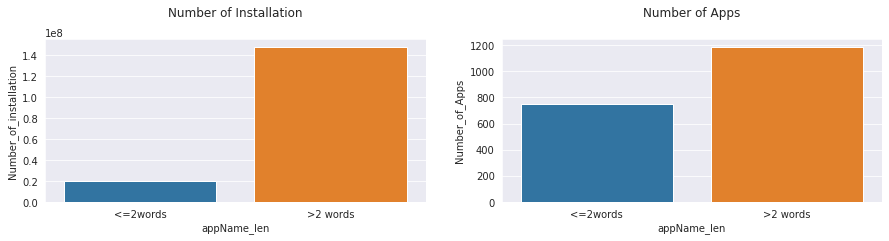

In [ ]:
# Lets first of all create a new column for checking the appName length
all_data['appName_len'] = ['>2 words' if len(x.split())>2 else '<=2words' for x in all_data['appName']]

app_install = all_data.groupby('appName_len')['installs'].agg('sum').reset_index(name='Number_of_installation')

data_apps = all_data.groupby('appName_len').size().reset_index(name='Number_of_Apps')

fig, axes = plt.subplots(figsize=(15,3), ncols=2, nrows=1)
axes[0].set_title('Number of Installation', y= 1.1)
axes[1].set_title('Number of Apps', y= 1.1)
In in
viz1 = sns.barplot(x=app_install.appName_len, y= app_install.Number_of_installation, ax=axes[0])
viz2 = sns.barplot(data_apps.appName_len, y = data_apps.Number_of_Apps, ax=axes[1])

plt.show(fig)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


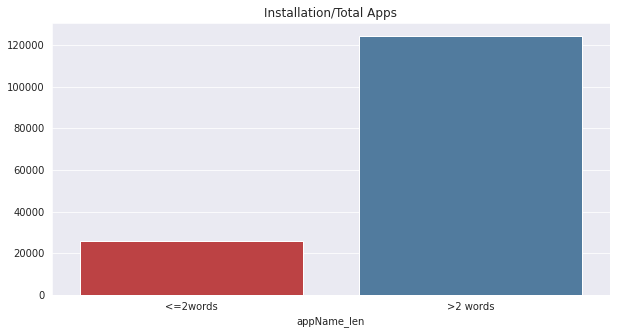

In [ ]:
# As we can see there are more apps with their names greater than 2 words than the ones with less number of names
# despite the huge imbalance in appName_len section. The <= 2words  are still downloaded less than the ones with >=2 words
# By statistics apps with >= 2 words are downloaded more
# But we will investigate this further before drawing a conclusion

#---- We can see that apps with name >=2 words are installed the most---

figure = plt.figure(figsize=(10, 5))
plt.title('Installation/Total Apps', y = 1.0)
viz3 = sns.barplot(data_apps.appName_len, y = app_install.Number_of_installation/data_apps.Number_of_Apps,
                   palette=sns.color_palette(palette='Set1', n_colors=2, desat=.8))
plt.show(figure)

In [ ]:
agg('sum').reset_index(name='Total ratings')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



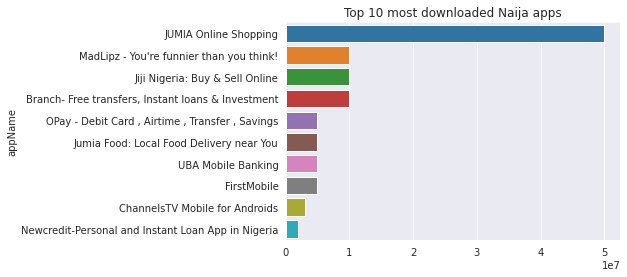

In [ ]:
# top ten most downloaded apps on playstore
App = all_data.groupby('appName').installs.sum().sort_values(ascending=False).head(10)
plt.title('Top 10 most downloaded Naija apps')
sns.barplot(App.values, App.index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



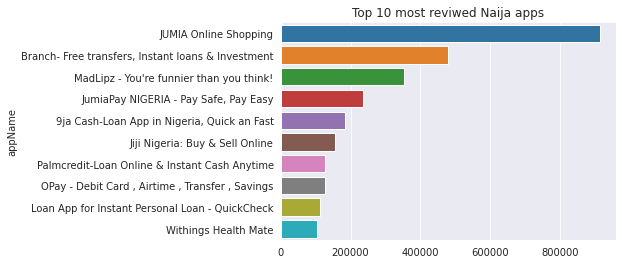

In [ ]:
# we can still see a positive correlation betweeen the installation and ratings on app level. More rated apps attract more downloads
appRating = all_data.groupby('appName').ratings.sum().sort_values(ascending=False).head(10)
plt.title('Top 10 most reviwed Naija apps')
bar = sns.barplot(appRating.values, appRating.index)
plt.show(bar)

# Game Data Analysis

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Naija Apps & Review/new csvs/find_game_csv_here/games.csv')
data.head(2)

,title,summary,free,genre,installs,ratings,price,size,contentRating,reviews,released,adSupported,sale,score,similarApps,version
0,Naija Ludo,Naija Ludo is a classic dice and race game for...,True,Board,"5,000,000+",20486.0,0.0,13M,Rated for 3+,8693,"Nov 5, 2015",True,False,4.280351,"['com.maliyo.whotking', 'io.yarsa.games.ludo',...",Apple
1,Naija Whot Pro,Naija Whot is a classic card game for all ages.,True,Card,"500,000+",1802.0,0.0,17M,Rated for 3+,900,"Dec 4, 2014",True,False,4.126374,"['com.tonielro.naijawhotfree', 'com.maliyo.who...",SEP_2021


In [ ]:
data.shape

(74, 16)

check For each of the app sizes and each category with various app sizes both for the highest and the least and compare their number of installation

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          74 non-null     object 
 1   summary        74 non-null     object 
 2   free           74 non-null     bool   
 3   genre          74 non-null     object 
 4   installs       74 non-null     object 
 5   ratings        45 non-null     float64
 6   price          74 non-null     float64
 7   size           74 non-null     object 
 8   contentRating  74 non-null     object 
 9   reviews        74 non-null     int64  
 10  released       74 non-null     object 
 11  adSupported    39 non-null     object 
 12  sale           74 non-null     bool   
 13  score          74 non-null     float64
 14  similarApps    70 non-null     object 
 15  version        74 non-null     object 
dtypes: bool(2), float64(3), int64(1), object(10)
memory usage: 8.4+ KB


In [ ]:
data.installs = data.installs.str.replace(',','')
data.installs = data.installs.str.replace('+','')
data.installs = [ int(i) for i in data.installs ]

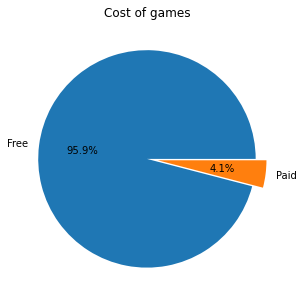

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
categories = ["Free","Paid"]
data_1 = data.free.value_counts()
explode = (0, 0.1)
fig = plt.figure(figsize = (10,5))
plt.title("Cost of games")
plt.pie(data_1, labels = categories, explode=explode, autopct='%1.1f%%')
plt.show()

95% of the games are free.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



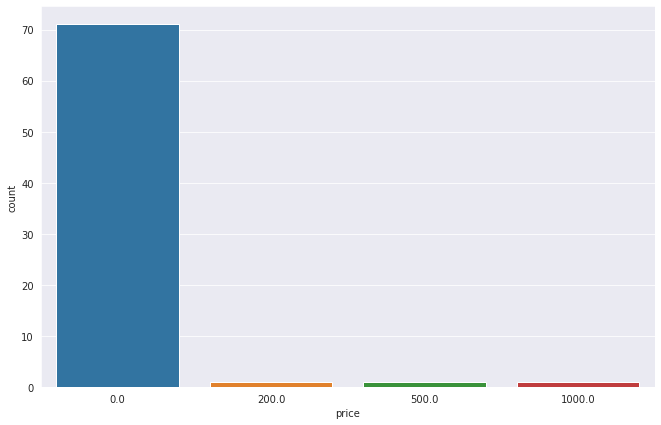

In [ ]:
plt.figure(figsize=(11,7))
sns.countplot(data.price)

Only 3 games were not free. Costing 200, 500 and 1000

In [ ]:
data.genre.value_counts()

Sports               23
Educational          11
Trivia                9
Adventure             6
Arcade                5
Action                4
Board                 3
Puzzle                3
Card                  3
Word                  1
Simulation            1
Education             1
Casual                1
Entertainment         1
Role Playing          1
Books & Reference     1
Name: genre, dtype: int64

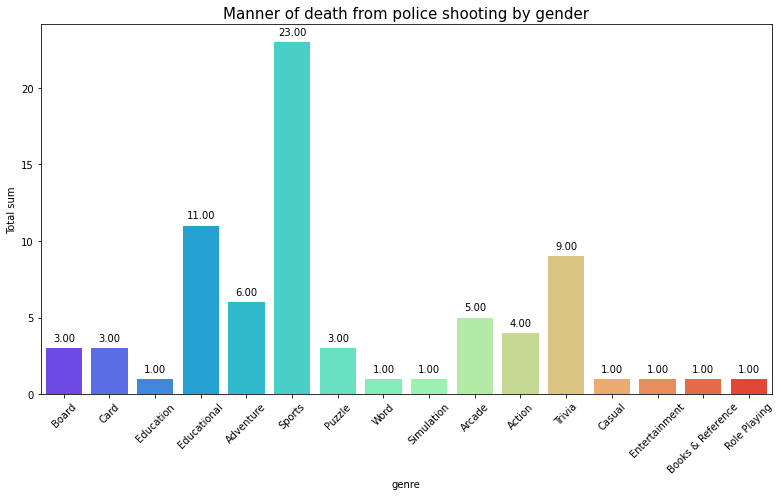

In [ ]:
plt.figure(figsize=(11,7))
plt.xticks(rotation=45)
sns.countplot(data.genre,palette='rainbow')

Sports games have the highest number of games available on play store

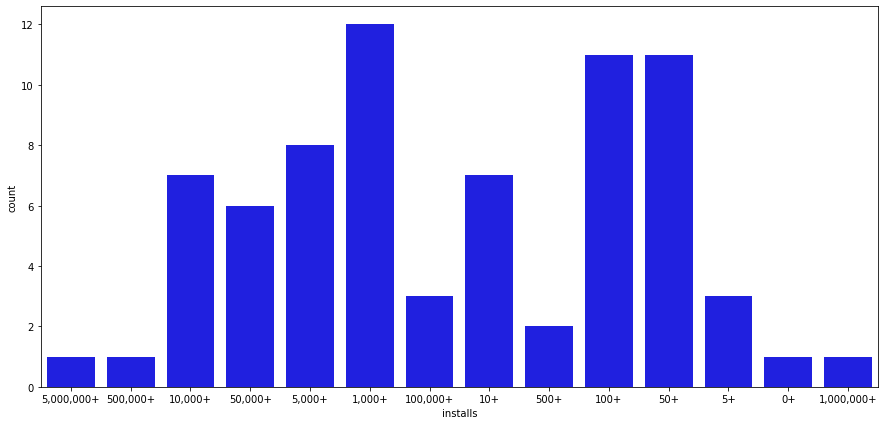

In [ ]:
sns.countplot(x=data.installs, color='blue')
plt.gcf().set_size_inches(15,7)

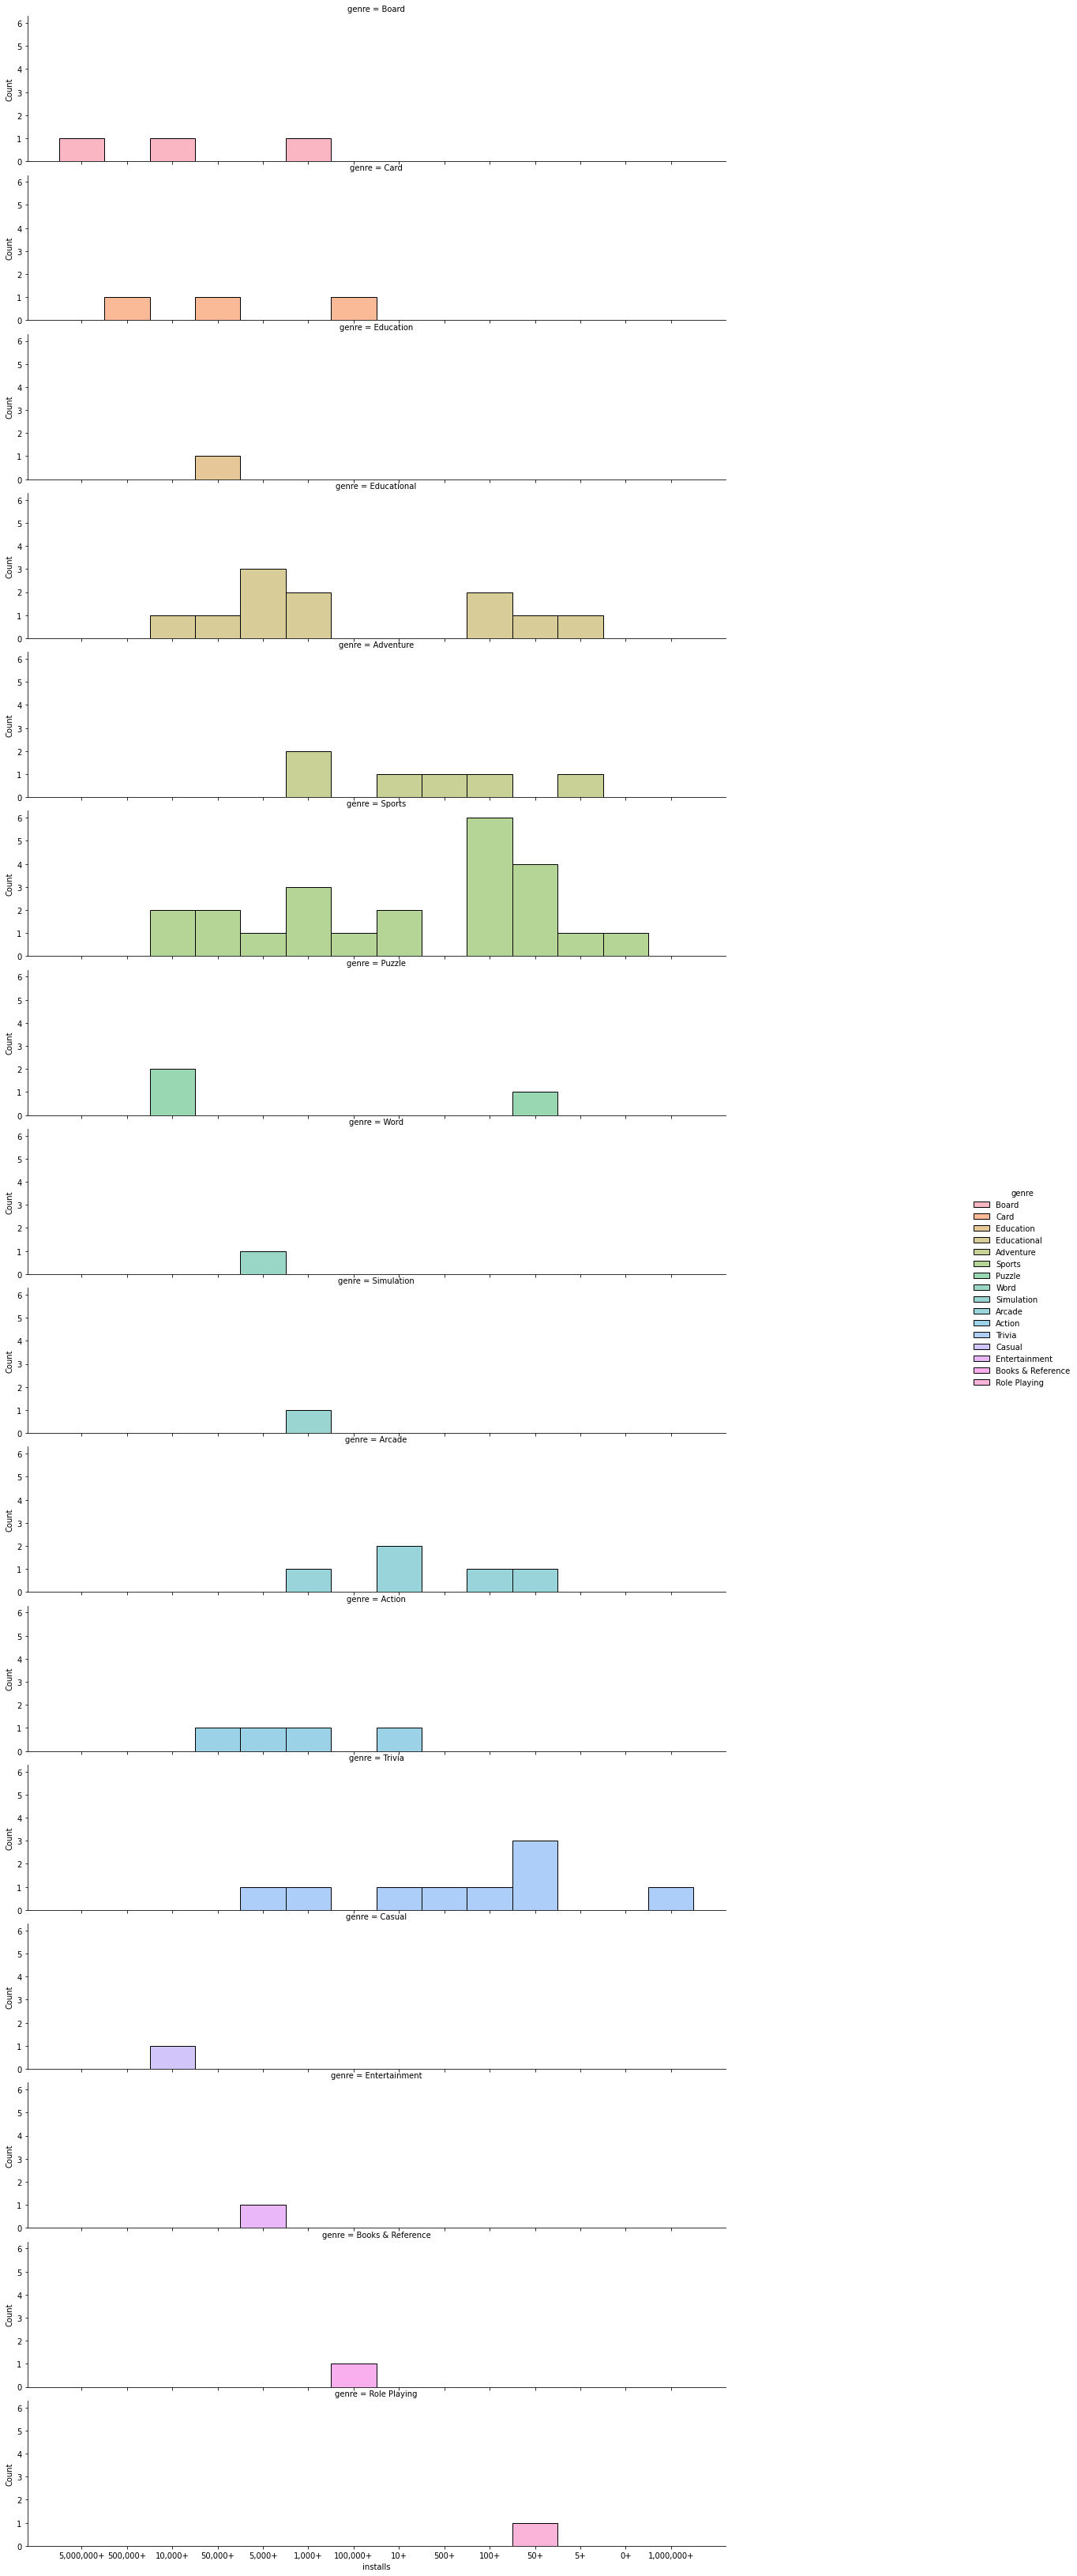

In [ ]:
sns.displot(x=data.installs, hue=data.genre, row=data.genre, discrete=True)
plt.gcf().set_size_inches(20,45)

most apps are usually around 1000 downloads

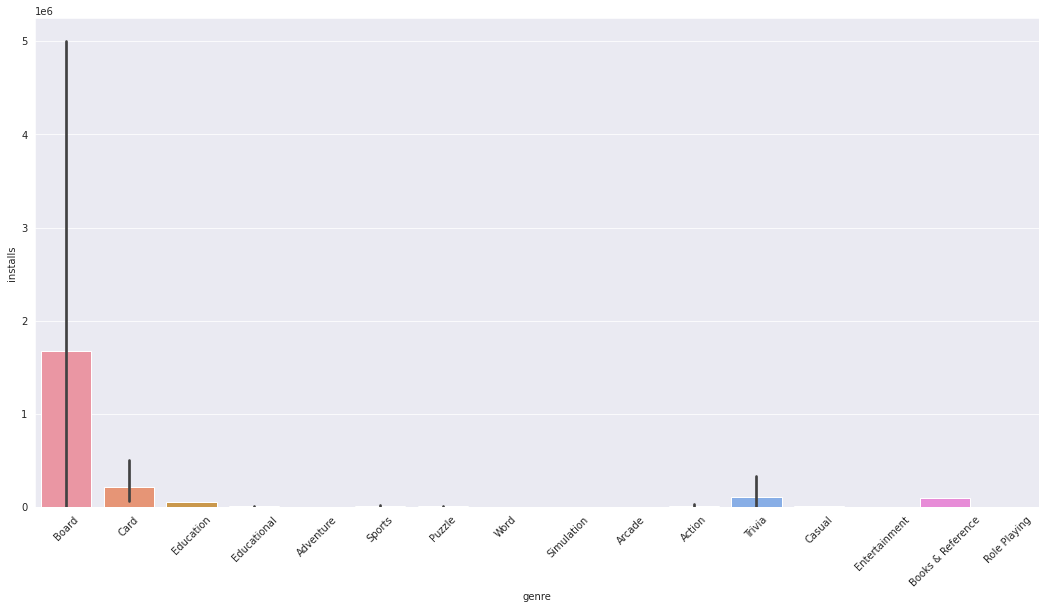

In [ ]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=45)
sns.barplot(x=data.genre,y=data.installs,)

Most downloaded app are board games

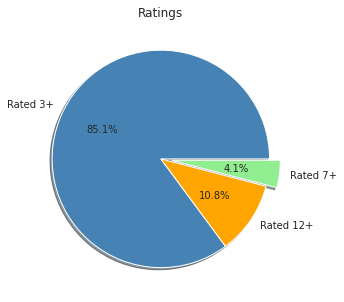

In [ ]:
categories = ["Rated 3+","Rated 12+", "Rated 7+"]
data_2 = data.contentRating.value_counts()
explode = (0, 0, 0.1)
fig = plt.figure(figsize = (10,5))
color_list = ['steelblue', 'orange', 'lightgreen'] 
plt.title("Ratings")
plt.pie(data_2, labels = categories, shadow=True, explode=explode, autopct='%1.1f%%', colors = color_list)
plt.show()

More than 3 quaters of the games are rated 3+. A small percentage are rated 7+ and 12+

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



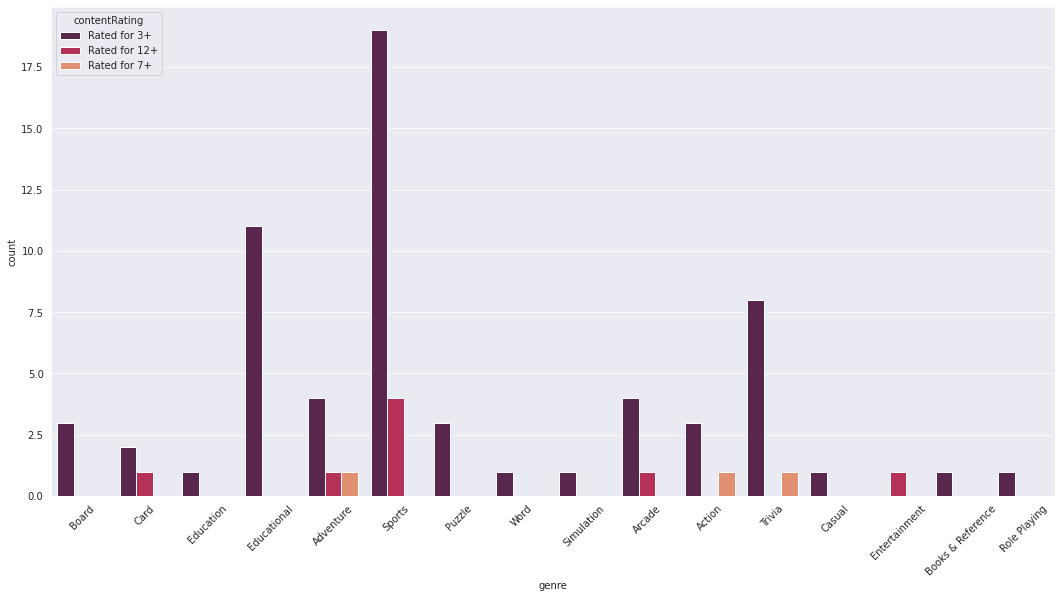

In [ ]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=45)
sns.countplot(data.genre,hue=data.contentRating,palette='rocket')

Again, there are more sports games on the App store and they make up most of the rated 3+ games

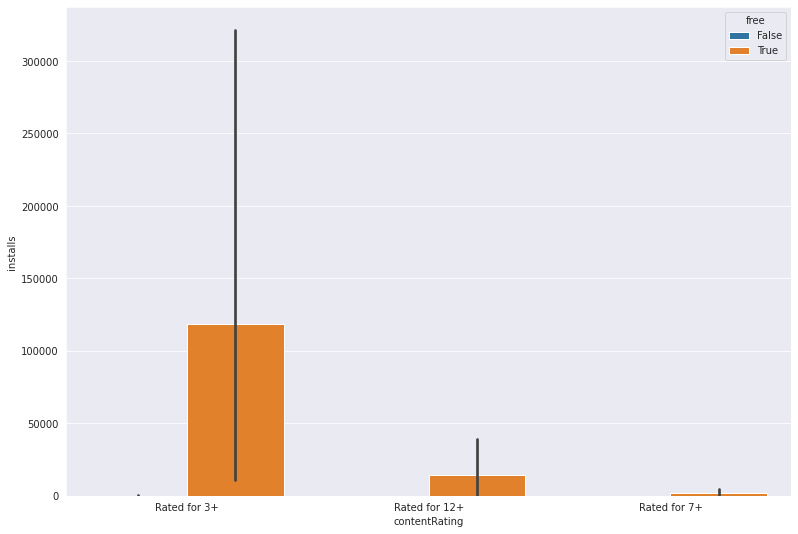

In [ ]:
plt.figure(figsize=(13,9))
sns.barplot(x=data.contentRating,y=data.installs,hue=data.free)

Games rated 3+ were the most downloaded. Most if not all apps are free.

In [ ]:
date_split = data.released.str.split(' ',expand=True)

In [ ]:
date_split.columns = ['month','day','year']

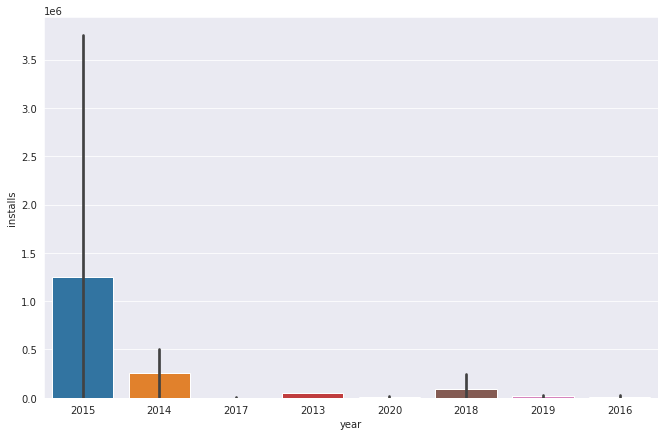

In [ ]:
plt.figure(figsize=(11,7))
sns.barplot(x=date_split.year,y=data.installs)

Games released in 2015 have the highest downloads

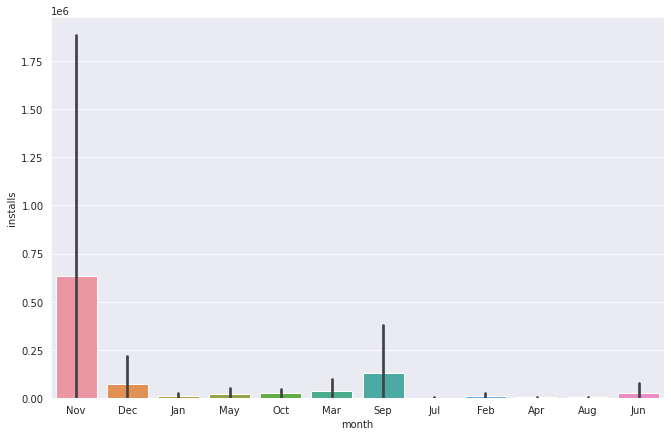

In [ ]:
plt.figure(figsize=(11,7))
sns.barplot(x=date_split.month,y=data.installs)

November has the highest download rate

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



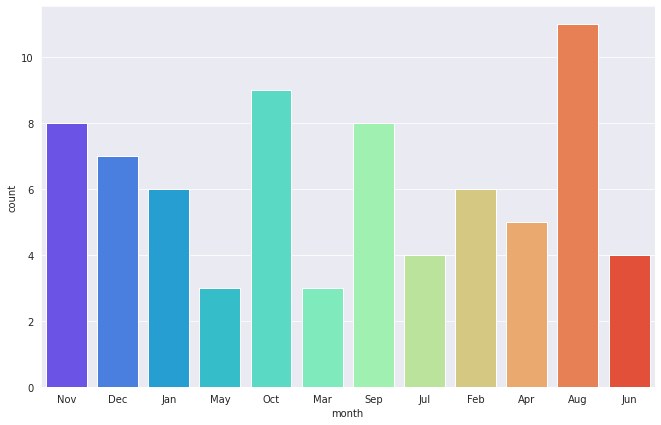

In [ ]:
plt.figure(figsize=(11,7))
sns.countplot(date_split.month,palette='rainbow')

August is the most common time to release a game

In [ ]:
data.adSupported.value_counts()

True    39
Name: adSupported, dtype: int64

39 apps support Ads, there is no data for regarding this for the rest of the 35 apps

In [ ]:
data.sale.value_counts()  #???none of the apps are for sale

False    74
Name: sale, dtype: int64

In [ ]:
#data.score.value_counts()   # not very useful information from this

In [ ]:
#data.version.value_counts()

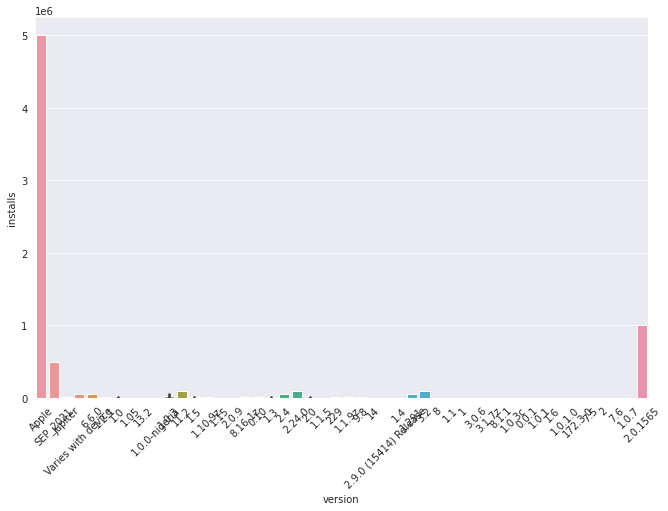

In [ ]:
plt.figure(figsize=(11,7))
plt.xticks(rotation=45)
#sns.countplot(data.version,palette='flare')
sns.barplot(x=data.version,y=data.installs)

Apple version seems to be the most downloaded from the above

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



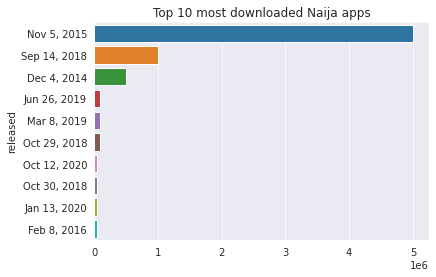

In [ ]:


# Lets look at the released data that had the most number of install
released_date = data.groupby('released').installs.sum().sort_values(ascending=False).head(10)
plt.title('Top 10 most downloaded Naija apps')
sns.barplot(released_date.values, released_date.index)